In [1]:
import rasterio as rio
import rasterio
import rasterio.mask
from rasterio.plot import plotting_extent
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import os
import seaborn as sns
import fiona
import json

In [2]:
with fiona.open("../ethiopia_shapefiles/gadm36_ETH_3.shp", "r") as shapefile:
    feats = [feature for feature in shapefile]

# whole country
ethiopia = [i['geometry'] for i in feats]

# oromia
oromia = [i['geometry'] for i in feats if i['properties']['NAME_1']=='Oromia']

# gambella
gambella = [i['geometry'] for i in feats if i['properties']['NAME_1']=='Gambela Peoples']

In [3]:
data = []
years = [2015, 2016, 2017, 2018]


for year in years: 

    with rasterio.open(f"tiffs/eth_predictions_{year}.tif") as src:
        out_image, out_transform = rasterio.mask.mask(src, 
                                                      gambella, # set the region to one of [ethiopia, oromia, gambella]
                                                      crop=True)
        out_meta = src.meta.copy()    

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(f"RGB.byte.masked.{year}.tif", "w", **out_meta) as dest:
        dest.write(out_image)    

    # masked to Ethiopia shape
    preds = rio.open(f'RGB.byte.masked.{year}.tif')
    
    data.append(preds)

In [4]:
cmap = plt.cm.rainbow
cmap.set_bad(color='black')

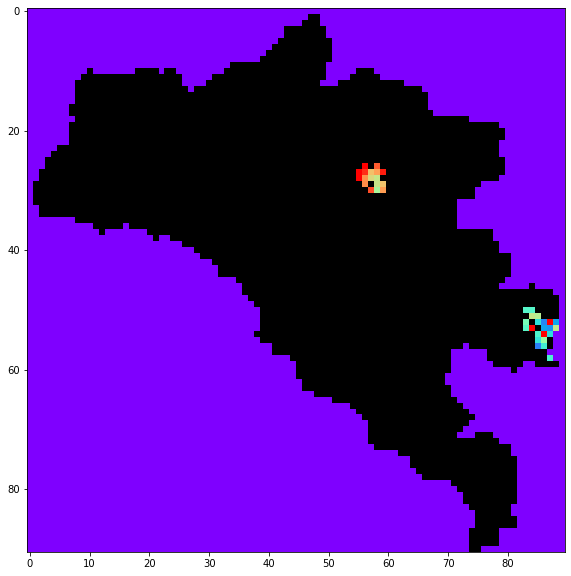

In [5]:
fig, ax = plt.subplots(figsize=(12,10))
chm_plot = ax.imshow(data[0].read(1), 
                     cmap=cmap,
                     vmin=0,
                     vmax=150)
# patches = [PolygonPatch(feature) for feature in features]
# ax.add_collection(mpl.collections.PatchCollection(patches))

[Text(0, 0, 'Low Yield'), Text(0, 0, 'Medium Yield'), Text(0, 0, 'High Yield')]

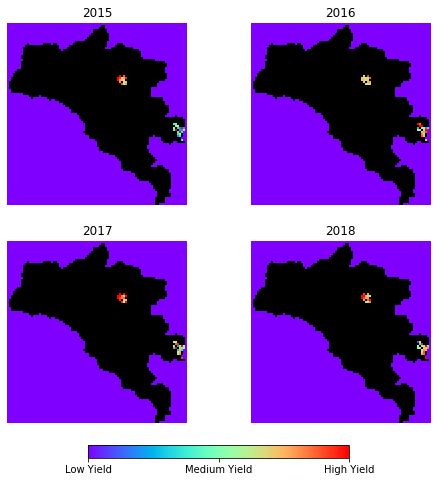

In [6]:
p = preds.read(1, masked=True) # Read the appropriate band
fig, axs = plt.subplots(2,2, figsize=(8,8), gridspec_kw={"height_ratios":[1, 1]})

cax = axs[0,0].imshow(data[0].read(1),cmap=cmap,vmin=0,vmax=150)
axs[0,0].set_title('2015')
axs[0,0].set_axis_off();

axs[0,1].imshow(data[1].read(1),cmap=cmap,vmin=0,vmax=150)
axs[0,1].set_title('2016')
axs[0,1].set_axis_off();

axs[1,0].imshow(data[2].read(1),cmap=cmap,vmin=0,vmax=150)
axs[1,0].set_title('2017')
axs[1,0].set_axis_off();

axs[1,1].imshow(data[3].read(1),cmap=cmap,vmin=0,vmax=150)
axs[1,1].set_title('2018')
axs[1,1].set_axis_off();

cbar = fig.colorbar(chm_plot, fraction=.03, ax=axs, ticks=[0, 75, 150], orientation="horizontal", pad=0.05)
cbar.ax.set_xticklabels(['Low Yield', 'Medium Yield', 'High Yield'])

In [7]:
fig.savefig(f"prediction_maps/gambella.png", dpi=180)